# Numba
- Uses just-in-time compilation to speed up certain calculations. It takes your function and converts to a machine code with LLVM library. The machine code is being executed whenever you call the function. Note: LLVM is not an acronym, it is the actual name of the project. 
- The main appraoch is to use numba.vectorize and numba.jit() decorator. Decorators modify a function in a uniform way. 
- Numba can parallelize a function on a single machine with multiple CPUs or GPUs. 

### Process vs Threads
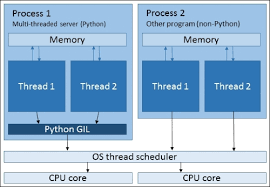


| Process                           | Threads |
|:----------------------------------| :---------------------------------- |
| Execution of a program            |A segment of a process (part of the code execution)              |
| More time to create or terminate  |  Less time for create or terminate  |
| Isolated                          |  Shares memory                      |


## Decorators
- Dynamically alters a function or method
- Applies the symbol "@" in front of a function
- A function 'f' can be vectorized with @numba.vectoroize decorator
- A serial function can be parallelized with @numba.jit decorator

## Vectorizing a function
**Example: Find the square root of the elements in an array**

In [ ]:
#Import relevant packages
import numpy as np
import numba
from numba import njit
from numba import jit
import time
numba.__version__

The square root is a vectorized function in NumPy. Here is the NumPy approach.

In [12]:
x = np.arange(int(1e6))
print("Time for executing np.sqrt(x)")
%timeit np.sqrt(x)

Time for executing np.sqrt(x)
1.29 ms ± 997 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Lets pretent that NumPy does not have a vectorized universal function for square root. Here is the python way of writing a loop. 

In [14]:
import math
print("Time for executing math.sqrt(x)")
%timeit [math.sqrt(xx) for xx in x]

Time for executing math.sqrt(x)
168 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here is Numba way to vectorize a function, just use the decorator @numba.vectorize. This is how we create our own universal functions. 

In [15]:
@numba.vectorize
def numba_sqrt(x):
  return math.sqrt(x)
print("Time for executing  @numba.vectorize (cpu_sqrt)")
%timeit numba_sqrt(x)

Time for executing  @numba.vectorize (cpu_sqrt)
843 µs ± 7.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Decorator - a simple example

In [1]:
# A simple hello world function
def hello():
  print('Hello world')

In [2]:
hello()

Hello world


In [3]:
# Write a function which takes a function as an argument and returns another function. 
def make_sure(func): 
  def wrapper():
    while 1:
      res = input('are you sure you want to greet? [y/n]')
      if res=='n':
        return
      elif res=='y':
        func()
        return
  return wrapper  

In [4]:
result_function = make_sure(hello)
print(type(result_function))
print(result_function())

<class 'function'>
are you sure you want to greet the world? [y/n]y
Hello world
None


Now lets use the above function of function to decorate the hello function. Decorator looks nice, compact, and wrapes th hello function.

In [5]:
@make_sure
def hello():
  print('Hello world')
  
hello()

are you sure you want to greet the world? [y/n]y
Hello world


### Numba Parallelism with @jit decorator
How to improve the performance of lloops? 
1. Vectorization
2. Parallelization

### Example: Monte Carlo PI estimate

In [23]:
import random

# Serial version
def monte_carlo_pi_serial(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

# Parallel version - Explicit with numba.prange 
@jit(nopython=True, parallel=True, nogil=True)
def monte_carlo_pi_explicit_parallel(nsamples):
    acc = 0
    # Only change is applying prange() function. 
    #for i in range(nsamples):
    for i in numba.prange(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [25]:
print("Time for running monte_carlo_pi_serial")
%time monte_carlo_pi_serial(int(1e8))

Time for running monte_carlo_pi_serial
CPU times: user 26.2 s, sys: 1.02 ms, total: 26.2 s
Wall time: 26.2 s


3.14191456

In [24]:
print("Time for running monte_carlo_pi_explicit_parallel")
%time monte_carlo_pi_explicit_parallel(int(1e8))

Time for running monte_carlo_pi_explicit_parallel
CPU times: user 2.26 s, sys: 410 ms, total: 2.67 s
Wall time: 471 ms


3.14164812

In [ ]:
print(numba.config.NUMBA_NUM_THREADS)

Numba uses all the available cores by default. Set the shell variable NUMBA_NUM_THREADS before starting the notebook. Dask has fine grained control on threads and processes. 

## Summary
- Numba can easily parallelize a function with JIT
- In a loop, do the explicit parallelism with numba.prange
- Functions can be parallelized to run on GPU hardware (Cuda JIT, not covered)